In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


import sys
ROOT = "../../"
sys.path.append(ROOT) # Add root directory to path

from src.utils.REPClassifier import REPClassifier
from src.utils.StandardDataset import StandardDataset
from src.utils.perturbations import *

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

In [2]:
# Step 1: Load the MNIST dataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [3]:
# Step 1a: Swap axes to PyTorch's NCHW format
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

In [29]:
# Step 2: Create the REPClassifier model
channel_widths = [1, 16, 32, 64, 32, 16]  
linear_sizes = [64, 32]
kernel = 3
pooling = nn.AdaptiveMaxPool2d((1, 1))

perturbation_description = [["Gaussian", 0.2],
                            ["Laplacian", 0.2],
                            ["Lp-norm", 2, 4],
                            ["Lp-norm", 2, 5],
                            ["Lp-norm", 2, 6],
                            ["Lp-norm", 2, 7],
                            ["Lp-norm", 2, float('inf')]]
perturbation_description = []

perturbations = create_perturbations(perturbation_description)
include_original = True
shuffle = True

model = REPClassifier(
    channel_widths=channel_widths,
    linear_sizes=linear_sizes,
    kernel=kernel,
    pooling=pooling,
    perturbations=perturbations,
    include_original=include_original,
    shuffle=shuffle,
    num_classes=10,
)

In [30]:
# Step 2a: Define the loss function and the optimizer
lr = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Step 3: Create the ART classifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

In [31]:
# Step 4: Train the ART classifier
batch_size = 64
super_epochs = 20
epochs_per = 1
training_history = []
for epoch in range(super_epochs):
    classifier.fit(x_train, y_train, batch_size=batch_size, nb_epochs=epochs_per, verbose=False)
    train_predictions = classifier.predict(x_train)
    train_accuracy = np.sum(np.argmax(train_predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
    test_predictions = classifier.predict(x_test)
    test_accuracy = np.sum(np.argmax(test_predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print(f"Epoch {(epoch+1)*epochs_per}/{super_epochs*epochs_per} Complete! Train Acc: {train_accuracy}, Test Acc: {test_accuracy}")

Epoch 1/20 Complete! Train Acc: 0.7901333333333334, Test Acc: 0.7948
Epoch 2/20 Complete! Train Acc: 0.84505, Test Acc: 0.8478


KeyboardInterrupt: 

In [21]:
test_history = []

def display_test_history(test_history):
    for i in range(len(test_history)):
        test = test_history[i]
        num_p = len(test['perturbations'])
        io = test['include_original']
        shuffle = test['shuffle']
        baseline = test['baseline_accuracy']
        adversarial = test['adversarial_accuracy']
        adv_str = f"{adversarial[0]*100}/{adversarial[1]*100}/{adversarial[2]*100}/{adversarial[3]*100}"
        print(f"Test {i}: Perturbations ({num_p}), Original ({io}), Shuffle ({shuffle}), Baseline ({baseline*100}%), Adversarial ({adv_str}%)")

# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
baseline_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(baseline_accuracy * 100))

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv1 = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv1)
adversarial_accuracy1 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples (epsilon = 0.1): {}%".format(adversarial_accuracy1 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv2 = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv2)
adversarial_accuracy2 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples (epsilon = 0.2): {}%".format(adversarial_accuracy2 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.3)
x_test_adv3 = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv3)
adversarial_accuracy3 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples (epsilon = 0.3): {}%".format(adversarial_accuracy3 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.5)
x_test_adv4 = attack.generate(x=x_test)
predictions = classifier.predict(x_test_adv4)
adversarial_accuracy4 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples (epsilon = 0.5): {}%".format(adversarial_accuracy4 * 100))

test_history.append({'channel_widths': channel_widths,
                    'linear_sizes': linear_sizes,
                    'kernel': kernel,
                    'pooling': pooling,
                    'perturbations': perturbation_description,
                    'include_original': include_original,
                    'shuffle': shuffle,
                    'loss': criterion,
                    'lr': lr,
                    'batch_size': batch_size,
                    'epochs': epochs,
                    'baseline_accuracy': baseline_accuracy,
                    'adversarial_accuracy': [adversarial_accuracy1, adversarial_accuracy2, adversarial_accuracy3, adversarial_accuracy4]})

Accuracy on benign test examples: 98.65%
Accuracy on adversarial test examples (epsilon = 0.1): 63.980000000000004%
Accuracy on adversarial test examples (epsilon = 0.2): 39.519999999999996%
Accuracy on adversarial test examples (epsilon = 0.3): 19.400000000000002%
Accuracy on adversarial test examples (epsilon = 0.5): 10.32%


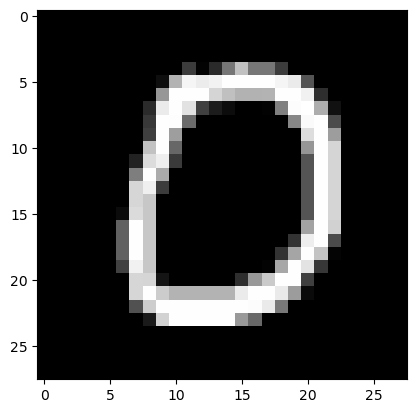

[0]


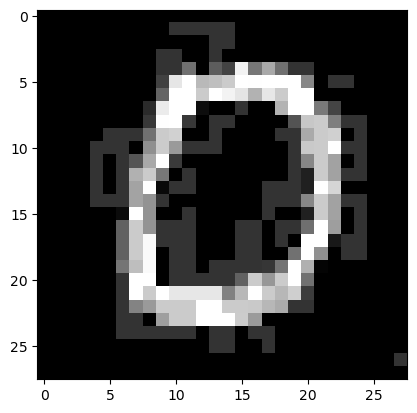

[6]


In [22]:
idx = 10

plt.figure()
plt.imshow(x_test[idx][0], cmap='gray')
plt.show()
print(np.argmax(classifier.predict(x_test[idx]), axis=1))

plt.figure()
plt.imshow(x_test_adv2[idx][0], cmap='gray')
plt.show()
print(np.argmax(classifier.predict(x_test_adv2[idx]), axis=1))


In [5]:
display_test_history(test_history)

Test 0: Perturbations (5), Original (False), Shuffle (False), Baseline (10.100000000000001%), Adversarial (10.100000000000001/10.100000000000001/10.100000000000001/10.100000000000001%)
Test 1: Perturbations (5), Original (True), Shuffle (False), Baseline (11.35%), Adversarial (11.35/11.35/11.35/11.35%)


In [59]:
best_i = 0
accuracy = 0
eps = 3
for i in range(len(test_history)):
    if test_history[i]['adversarial_accuracy'][eps] > accuracy:
        best_i = i
        accuracy = test_history[i]['adversarial_accuracy'][eps]
print(test_history[best_i])

{'channel_widths': [1, 4, 10], 'linear_sizes': [100], 'kernel': 5, 'pooling': AdaptiveMaxPool2d(output_size=(1, 1)), 'perturbations': [['Gaussian', 1.0]], 'include_original': False, 'shuffle': True, 'loss': CrossEntropyLoss(), 'lr': 0.01, 'batch_size': 64, 'epochs': 10, 'baseline_accuracy': 0.4276, 'adversarial_accuracy': [0.3746, 0.2964, 0.2196, 0.1436]}


In [62]:
import csv

def save_to_csv(data, filename):
    if not data:
        return

    # Extract the keys from the first dictionary as headers
    headers = list(data[0].keys())

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)

        # Write the headers
        writer.writeheader()

        # Write each dictionary as a row in the CSV file
        for item in data:
            writer.writerow(item)

    print(f"Data saved to {filename} successfully.")

save_to_csv(test_history, ROOT + "notebooks/experiment_log/testing_round_2.csv")

Data saved to ../../notebooks/experiment_log/testing_round_1.csv successfully.
